# 第6章 グラフニューラルネットワーク

### 必要なライブラリのインストール

In [1]:
# 依存ライブラリのインストール
!pip uninstall -y fastai torch torchaudio torchdata torchtext torchvision
!pip install torch==2.0.0+cpu --index-url https://download.pytorch.org/whl/cpu
!pip install torch-cluster torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-2.0.0+cpu.html

# 必要なライブラリのインストール
!pip install torch-geometric==2.3.1

Found existing installation: fastai 2.7.18
Uninstalling fastai-2.7.18:
  Successfully uninstalled fastai-2.7.18
Found existing installation: torch 2.5.1+cu124
Uninstalling torch-2.5.1+cu124:
  Successfully uninstalled torch-2.5.1+cu124
Found existing installation: torchaudio 2.5.1+cu124
Uninstalling torchaudio-2.5.1+cu124:
  Successfully uninstalled torchaudio-2.5.1+cu124
Found existing installation: torchvision 0.20.1+cu124
Uninstalling torchvision-0.20.1+cu124:
  Successfully uninstalled torchvision-0.20.1+cu124
Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 MB 6.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
timm 1.0.14 requires torchvision, which is not installed.
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Coraデータセットのダウンロード

In [2]:
# 必要なライブラリのインポート
from torch_geometric.datasets import Planetoid

# torch_geometric の Dataset としてダウンロード
dataset = Planetoid(root="./dataset", name="Cora", split="full")

Processing...
Done!


### データセットの前処理

`RandomNodeSplit`を利用して、ネットワーク中のノードを学習データとテストデータに分割します。
分割された結果として得られる`splitted_data`の`train_mask`や`test_mask`で学習データとテストデータの区別ができます。

In [3]:
from torch_geometric.transforms import RandomNodeSplit

# ノードを学習データとテストデータに分割
node_splitter = RandomNodeSplit(
    split="train_rest",  # 分割方法
    num_splits=1,        # 分割数
    num_val=0.0,         # 検証データの割合
    num_test=0.4,        # テストデータの割合
    key="y",             # 正解データの属性名
)
splitted_data = node_splitter(dataset._data)
print(splitted_data.node_attrs())
print(splitted_data.train_mask)
print(splitted_data.test_mask)

['test_mask', 'val_mask', 'y', 'train_mask', 'x']
tensor([ True,  True,  True,  ..., False,  True, False])
tensor([False, False, False,  ...,  True, False,  True])


## 6.8.1 GNN による論文の技術領域の分類

まずは、GCNによるノード分類モデルを構築します。PyTorch Geometricで用意されている`GCNConv`をフィルタとして用いることで、容易にモデルの実装が可能です。

In [5]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, Sequential


# GCNモデルの定義
class GCN(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,  # 入力層の次元数 = ノードの特徴量の次元数
        projection_dim: int,     # 中間層の次元数
        num_classes: int,        # 出力層の次元数 = 分類先のクラス数
    ) -> None:
        super().__init__()
        self.conv1 = GCNConv(num_node_features, projection_dim)
        self.conv2 = GCNConv(projection_dim, num_classes)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [6]:
# GCNモデルのインスタンス化
device = "cuda" if torch.cuda.is_available() else "cpu"
gcn_model = GCN(
    num_node_features=dataset.num_node_features,
    projection_dim=64,
    num_classes=dataset.num_classes,
).to(device)

# 最適化アルゴリズムの選択
gcn_optimizer = torch.optim.Adam(list(gcn_model.parameters()), lr=0.01)

学習を行います。`GCN`をインスタンス化した`gcn_model`にPyTorch Geometricの`Data`オブジェクトを入力すると、各ノードの予測ラベルが出力されます。ここでは、`train_mask`で学習用のデータに限定して交差エントロピーを計算して誤差逆伝播によりパラメータを更新していきます。

またここでは、200エポック学習を行うこととします。

In [7]:
from tqdm import tqdm


# GCNの学習を行う関数の定義
def train_gcn() -> float:
    gcn_model.train()
    total_loss = 0.0
    gcn_optimizer.zero_grad()
    out = gcn_model(splitted_data)
    loss = F.cross_entropy(
        out[splitted_data.train_mask],
        splitted_data.y[splitted_data.train_mask],
    )
    loss.backward()
    gcn_optimizer.step()
    return loss.item()


# GCNの学習の実行
for epoch in tqdm(range(200)):
    loss = train_gcn()
    print(f"train loss : {loss:.4f}")

  2%|▏         | 4/200 [00:00<00:13, 14.76it/s]

train loss : 1.9430
train loss : 1.7193
train loss : 1.5035
train loss : 1.2935


  4%|▍         | 8/200 [00:00<00:11, 16.35it/s]

train loss : 1.0957
train loss : 0.9162
train loss : 0.7769
train loss : 0.6643


  6%|▌         | 12/200 [00:00<00:10, 17.25it/s]

train loss : 0.5580
train loss : 0.4853
train loss : 0.4152
train loss : 0.3730


  9%|▉         | 18/200 [00:00<00:08, 22.45it/s]

train loss : 0.3238
train loss : 0.3053
train loss : 0.2753
train loss : 0.2548
train loss : 0.2381
train loss : 0.2213


 12%|█▏        | 24/200 [00:01<00:07, 24.28it/s]

train loss : 0.2180
train loss : 0.2083
train loss : 0.1974
train loss : 0.1870
train loss : 0.1743
train loss : 0.1552


 15%|█▌        | 30/200 [00:01<00:06, 25.10it/s]

train loss : 0.1650
train loss : 0.1585
train loss : 0.1521
train loss : 0.1434
train loss : 0.1323
train loss : 0.1395


 18%|█▊        | 36/200 [00:01<00:06, 26.20it/s]

train loss : 0.1274
train loss : 0.1223
train loss : 0.1092
train loss : 0.1049
train loss : 0.1044
train loss : 0.1050


 21%|██        | 42/200 [00:01<00:05, 26.56it/s]

train loss : 0.1031
train loss : 0.0953
train loss : 0.1025
train loss : 0.0971
train loss : 0.0982
train loss : 0.0883


 24%|██▍       | 48/200 [00:02<00:05, 26.08it/s]

train loss : 0.0824
train loss : 0.0867
train loss : 0.0814
train loss : 0.0780
train loss : 0.0822
train loss : 0.0772


 27%|██▋       | 54/200 [00:02<00:05, 25.43it/s]

train loss : 0.0758
train loss : 0.0749
train loss : 0.0718
train loss : 0.0666
train loss : 0.0672
train loss : 0.0652


 30%|███       | 60/200 [00:02<00:05, 26.07it/s]

train loss : 0.0703
train loss : 0.0643
train loss : 0.0646
train loss : 0.0617
train loss : 0.0646
train loss : 0.0575


 33%|███▎      | 66/200 [00:02<00:05, 26.51it/s]

train loss : 0.0617
train loss : 0.0567
train loss : 0.0560
train loss : 0.0550
train loss : 0.0555
train loss : 0.0610


 36%|███▌      | 72/200 [00:03<00:04, 26.80it/s]

train loss : 0.0539
train loss : 0.0559
train loss : 0.0526
train loss : 0.0506
train loss : 0.0554
train loss : 0.0501


 39%|███▉      | 78/200 [00:03<00:04, 26.32it/s]

train loss : 0.0494
train loss : 0.0472
train loss : 0.0462
train loss : 0.0482
train loss : 0.0449
train loss : 0.0458


 42%|████▏     | 84/200 [00:03<00:04, 26.09it/s]

train loss : 0.0446
train loss : 0.0422
train loss : 0.0403
train loss : 0.0410
train loss : 0.0434
train loss : 0.0418


 45%|████▌     | 90/200 [00:03<00:04, 26.84it/s]

train loss : 0.0409
train loss : 0.0383
train loss : 0.0397
train loss : 0.0375
train loss : 0.0389
train loss : 0.0406


 48%|████▊     | 96/200 [00:03<00:03, 26.82it/s]

train loss : 0.0382
train loss : 0.0395
train loss : 0.0394
train loss : 0.0371
train loss : 0.0381
train loss : 0.0371


 51%|█████     | 102/200 [00:04<00:03, 26.30it/s]

train loss : 0.0353
train loss : 0.0399
train loss : 0.0332
train loss : 0.0375
train loss : 0.0394
train loss : 0.0353


 54%|█████▍    | 108/200 [00:04<00:03, 25.69it/s]

train loss : 0.0345
train loss : 0.0333
train loss : 0.0326
train loss : 0.0326
train loss : 0.0346
train loss : 0.0304


 57%|█████▋    | 114/200 [00:04<00:03, 26.03it/s]

train loss : 0.0327
train loss : 0.0309
train loss : 0.0325
train loss : 0.0310
train loss : 0.0324
train loss : 0.0319


 60%|██████    | 120/200 [00:04<00:03, 26.14it/s]

train loss : 0.0305
train loss : 0.0300
train loss : 0.0275
train loss : 0.0300
train loss : 0.0313
train loss : 0.0284


 63%|██████▎   | 126/200 [00:05<00:02, 25.63it/s]

train loss : 0.0315
train loss : 0.0293
train loss : 0.0299
train loss : 0.0284
train loss : 0.0272
train loss : 0.0277


 64%|██████▍   | 129/200 [00:05<00:02, 25.00it/s]

train loss : 0.0239
train loss : 0.0290
train loss : 0.0251
train loss : 0.0252
train loss : 0.0301


 68%|██████▊   | 135/200 [00:05<00:02, 24.65it/s]

train loss : 0.0265
train loss : 0.0282
train loss : 0.0239
train loss : 0.0277
train loss : 0.0248
train loss : 0.0239


 70%|███████   | 141/200 [00:05<00:02, 25.91it/s]

train loss : 0.0245
train loss : 0.0223
train loss : 0.0238
train loss : 0.0252
train loss : 0.0230
train loss : 0.0232


 74%|███████▎  | 147/200 [00:05<00:01, 26.64it/s]

train loss : 0.0213
train loss : 0.0231
train loss : 0.0211
train loss : 0.0226
train loss : 0.0211
train loss : 0.0218


 76%|███████▋  | 153/200 [00:06<00:01, 26.27it/s]

train loss : 0.0226
train loss : 0.0212
train loss : 0.0208
train loss : 0.0230
train loss : 0.0210
train loss : 0.0232


 80%|███████▉  | 159/200 [00:06<00:01, 26.43it/s]

train loss : 0.0217
train loss : 0.0189
train loss : 0.0190
train loss : 0.0223
train loss : 0.0202
train loss : 0.0203


 82%|████████▎ | 165/200 [00:06<00:01, 26.27it/s]

train loss : 0.0215
train loss : 0.0191
train loss : 0.0209
train loss : 0.0201
train loss : 0.0168
train loss : 0.0207


 86%|████████▌ | 171/200 [00:06<00:01, 26.57it/s]

train loss : 0.0206
train loss : 0.0201
train loss : 0.0168
train loss : 0.0193
train loss : 0.0180
train loss : 0.0200


 88%|████████▊ | 177/200 [00:07<00:00, 26.84it/s]

train loss : 0.0195
train loss : 0.0203
train loss : 0.0190
train loss : 0.0209
train loss : 0.0187
train loss : 0.0171


 92%|█████████▏| 183/200 [00:07<00:00, 26.50it/s]

train loss : 0.0170
train loss : 0.0189
train loss : 0.0165
train loss : 0.0174
train loss : 0.0194
train loss : 0.0177


 94%|█████████▍| 189/200 [00:07<00:00, 25.94it/s]

train loss : 0.0168
train loss : 0.0157
train loss : 0.0167
train loss : 0.0145
train loss : 0.0162
train loss : 0.0167


 98%|█████████▊| 195/200 [00:07<00:00, 26.63it/s]

train loss : 0.0154
train loss : 0.0159
train loss : 0.0152
train loss : 0.0180
train loss : 0.0166
train loss : 0.0156


100%|██████████| 200/200 [00:07<00:00, 25.29it/s]

train loss : 0.0159
train loss : 0.0178
train loss : 0.0160


scikit-learnの`classification_report`を用いて、分類性能を出力します。
学習時とは対照的に、`test_mask`でテストデータに限定をしてから性能評価を行う関数に入力します。

In [8]:
from sklearn.metrics import classification_report

y_true = splitted_data.y[splitted_data.test_mask].numpy()

# 評価データに対する推論
with torch.no_grad():
    gcn_model.eval()
    out = gcn_model(splitted_data)
    y_pred = out.argmax(dim=1)[splitted_data.test_mask]

# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.81      0.76       144
           1       0.89      0.72      0.80        92
           2       0.90      0.94      0.92       163
           3       0.90      0.88      0.89       325
           4       0.88      0.87      0.87       171
           5       0.82      0.86      0.84       123
           6       0.87      0.80      0.83        65

    accuracy                           0.86      1083
   macro avg       0.85      0.84      0.84      1083
weighted avg       0.86      0.86      0.86      1083



## 6.8.2 フィルタの差し替え

GCNをGraphSAGEに差し替えて学習と評価を行います。基本的な操作としては、これまで`GCNConv`としてた箇所を`SAGEConv`に置き換えるのみです。

In [9]:
from torch_geometric.nn import SAGEConv


# GraphSAGEモデルの定義
class GraphSAGE(torch.nn.Module):

    def __init__(
        self,
        num_node_features: int,  # 入力層の次元数 = ノードの特徴量の次元数
        projection_dim: int,     # 中間層の次元数
        num_classes: int,        # 出力層の次元数 = 分類先のクラス数
    ) -> None:
        super().__init__()
        self.conv1 = SAGEConv(num_node_features, projection_dim)
        self.conv2 = SAGEConv(projection_dim, num_classes)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [10]:
# GraphSAGEモデルのインスタンス化
device = "cuda" if torch.cuda.is_available() else "cpu"
sage_model = GraphSAGE(
    num_node_features=dataset.num_node_features,
    projection_dim=64,
    num_classes=dataset.num_classes,
).to(device)
sage_optimizer = torch.optim.Adam(list(sage_model.parameters()), lr=0.01)

In [11]:
# GraphSAGEモデルの学習を行う関数の定義
def train_sage() -> float:
    sage_model.train()
    total_loss = 0
    sage_optimizer.zero_grad()
    out = sage_model(splitted_data)
    loss = F.cross_entropy(
        out[splitted_data.train_mask],
        splitted_data.y[splitted_data.train_mask],
    )
    loss.backward()
    sage_optimizer.step()
    return loss.item()


# GraphSAGEモデルの学習の実行
for epoch in tqdm(range(1, 201)):
    loss = train_sage()
    print(f"train loss : {loss:.4f}")


  1%|          | 2/200 [00:00<00:30,  6.39it/s]

train loss : 1.9407
train loss : 1.6494


  2%|▏         | 4/200 [00:00<00:26,  7.28it/s]

train loss : 1.3409
train loss : 1.0254


  3%|▎         | 6/200 [00:00<00:25,  7.72it/s]

train loss : 0.7893
train loss : 0.5785


  4%|▍         | 8/200 [00:01<00:24,  7.75it/s]

train loss : 0.4253
train loss : 0.3406


  5%|▌         | 10/200 [00:01<00:23,  8.07it/s]

train loss : 0.2677
train loss : 0.2184


  6%|▌         | 12/200 [00:01<00:23,  8.16it/s]

train loss : 0.1965
train loss : 0.1480


  7%|▋         | 14/200 [00:01<00:23,  8.05it/s]

train loss : 0.1382
train loss : 0.1085


  8%|▊         | 16/200 [00:02<00:23,  7.99it/s]

train loss : 0.0985
train loss : 0.1004


  9%|▉         | 18/200 [00:02<00:22,  7.98it/s]

train loss : 0.0816
train loss : 0.0748


 10%|█         | 20/200 [00:02<00:22,  8.03it/s]

train loss : 0.0593
train loss : 0.0502


 11%|█         | 22/200 [00:02<00:22,  8.07it/s]

train loss : 0.0488
train loss : 0.0448


 12%|█▏        | 24/200 [00:03<00:22,  7.85it/s]

train loss : 0.0407
train loss : 0.0320


 13%|█▎        | 26/200 [00:03<00:21,  7.92it/s]

train loss : 0.0301
train loss : 0.0287


 14%|█▍        | 28/200 [00:03<00:21,  7.92it/s]

train loss : 0.0229
train loss : 0.0207


 15%|█▌        | 30/200 [00:03<00:21,  8.01it/s]

train loss : 0.0178
train loss : 0.0189


 16%|█▌        | 32/200 [00:04<00:21,  7.67it/s]

train loss : 0.0166
train loss : 0.0129


 17%|█▋        | 34/200 [00:04<00:20,  8.00it/s]

train loss : 0.0108
train loss : 0.0146


 18%|█▊        | 36/200 [00:04<00:20,  8.11it/s]

train loss : 0.0109
train loss : 0.0113


 19%|█▉        | 38/200 [00:04<00:20,  8.03it/s]

train loss : 0.0135
train loss : 0.0067


 20%|██        | 40/200 [00:05<00:20,  7.97it/s]

train loss : 0.0079
train loss : 0.0073


 21%|██        | 42/200 [00:05<00:20,  7.80it/s]

train loss : 0.0066
train loss : 0.0058


 22%|██▏       | 44/200 [00:05<00:19,  7.95it/s]

train loss : 0.0050
train loss : 0.0063


 23%|██▎       | 46/200 [00:05<00:18,  8.24it/s]

train loss : 0.0065
train loss : 0.0065


 24%|██▍       | 48/200 [00:06<00:19,  7.92it/s]

train loss : 0.0067
train loss : 0.0069


 25%|██▌       | 50/200 [00:06<00:21,  7.02it/s]

train loss : 0.0056
train loss : 0.0044


 26%|██▌       | 51/200 [00:06<00:24,  6.04it/s]

train loss : 0.0040


 26%|██▌       | 52/200 [00:06<00:27,  5.42it/s]

train loss : 0.0052


 26%|██▋       | 53/200 [00:07<00:28,  5.20it/s]

train loss : 0.0055


 27%|██▋       | 54/200 [00:07<00:28,  5.11it/s]

train loss : 0.0041


 28%|██▊       | 55/200 [00:07<00:33,  4.37it/s]

train loss : 0.0046


 28%|██▊       | 56/200 [00:07<00:35,  4.01it/s]

train loss : 0.0030


 28%|██▊       | 57/200 [00:08<00:38,  3.70it/s]

train loss : 0.0033


 29%|██▉       | 58/200 [00:08<00:45,  3.11it/s]

train loss : 0.0039


 30%|██▉       | 59/200 [00:09<00:52,  2.68it/s]

train loss : 0.0034


 30%|███       | 60/200 [00:09<01:02,  2.25it/s]

train loss : 0.0034


 30%|███       | 61/200 [00:10<01:00,  2.30it/s]

train loss : 0.0038


 31%|███       | 62/200 [00:10<01:01,  2.26it/s]

train loss : 0.0033


 32%|███▏      | 63/200 [00:11<01:02,  2.20it/s]

train loss : 0.0022


 32%|███▏      | 64/200 [00:11<01:00,  2.23it/s]

train loss : 0.0022


 32%|███▎      | 65/200 [00:11<00:57,  2.33it/s]

train loss : 0.0038


 33%|███▎      | 66/200 [00:12<00:50,  2.65it/s]

train loss : 0.0033


 34%|███▎      | 67/200 [00:12<00:47,  2.80it/s]

train loss : 0.0036


 34%|███▍      | 68/200 [00:12<00:46,  2.87it/s]

train loss : 0.0023


 35%|███▌      | 70/200 [00:13<00:37,  3.49it/s]

train loss : 0.0021
train loss : 0.0029


 36%|███▌      | 71/200 [00:13<00:36,  3.55it/s]

train loss : 0.0036


 36%|███▌      | 72/200 [00:13<00:35,  3.61it/s]

train loss : 0.0032


 36%|███▋      | 73/200 [00:14<00:32,  3.91it/s]

train loss : 0.0022


 37%|███▋      | 74/200 [00:14<00:30,  4.07it/s]

train loss : 0.0028


 38%|███▊      | 75/200 [00:14<00:30,  4.14it/s]

train loss : 0.0022


 38%|███▊      | 76/200 [00:14<00:32,  3.81it/s]

train loss : 0.0016


 38%|███▊      | 77/200 [00:15<00:30,  4.02it/s]

train loss : 0.0035


 40%|███▉      | 79/200 [00:15<00:26,  4.49it/s]

train loss : 0.0021
train loss : 0.0020


 40%|████      | 81/200 [00:15<00:25,  4.76it/s]

train loss : 0.0036
train loss : 0.0019


 42%|████▏     | 83/200 [00:16<00:22,  5.15it/s]

train loss : 0.0022
train loss : 0.0017


 42%|████▏     | 84/200 [00:16<00:22,  5.21it/s]

train loss : 0.0024


 43%|████▎     | 86/200 [00:16<00:22,  5.09it/s]

train loss : 0.0035
train loss : 0.0017


 44%|████▎     | 87/200 [00:16<00:23,  4.91it/s]

train loss : 0.0015


 44%|████▍     | 88/200 [00:17<00:23,  4.86it/s]

train loss : 0.0021


 44%|████▍     | 89/200 [00:17<00:24,  4.62it/s]

train loss : 0.0018


 45%|████▌     | 90/200 [00:17<00:28,  3.89it/s]

train loss : 0.0034


 46%|████▌     | 91/200 [00:18<00:29,  3.75it/s]

train loss : 0.0015


 46%|████▌     | 92/200 [00:18<00:27,  3.86it/s]

train loss : 0.0026


 46%|████▋     | 93/200 [00:18<00:31,  3.38it/s]

train loss : 0.0015


 47%|████▋     | 94/200 [00:18<00:29,  3.59it/s]

train loss : 0.0023


 48%|████▊     | 96/200 [00:19<00:26,  3.88it/s]

train loss : 0.0022
train loss : 0.0019


 48%|████▊     | 97/200 [00:19<00:28,  3.60it/s]

train loss : 0.0027


 49%|████▉     | 98/200 [00:20<00:30,  3.30it/s]

train loss : 0.0014


 50%|████▉     | 99/200 [00:20<00:28,  3.54it/s]

train loss : 0.0025


 50%|█████     | 100/200 [00:20<00:26,  3.75it/s]

train loss : 0.0013


 50%|█████     | 101/200 [00:20<00:28,  3.45it/s]

train loss : 0.0014


 52%|█████▏    | 103/200 [00:21<00:27,  3.55it/s]

train loss : 0.0017
train loss : 0.0019


 52%|█████▏    | 104/200 [00:21<00:24,  3.85it/s]

train loss : 0.0023


 52%|█████▎    | 105/200 [00:22<00:29,  3.23it/s]

train loss : 0.0013


 53%|█████▎    | 106/200 [00:22<00:30,  3.06it/s]

train loss : 0.0014


 54%|█████▎    | 107/200 [00:23<00:37,  2.47it/s]

train loss : 0.0014


 55%|█████▍    | 109/200 [00:23<00:27,  3.25it/s]

train loss : 0.0014
train loss : 0.0016


 56%|█████▌    | 111/200 [00:23<00:21,  4.09it/s]

train loss : 0.0037
train loss : 0.0017


 56%|█████▋    | 113/200 [00:24<00:18,  4.79it/s]

train loss : 0.0012
train loss : 0.0010


 57%|█████▊    | 115/200 [00:24<00:16,  5.24it/s]

train loss : 0.0013
train loss : 0.0018


 58%|█████▊    | 117/200 [00:24<00:14,  5.89it/s]

train loss : 0.0020
train loss : 0.0011


 60%|█████▉    | 119/200 [00:25<00:12,  6.64it/s]

train loss : 0.0014
train loss : 0.0012


 60%|██████    | 121/200 [00:25<00:10,  7.40it/s]

train loss : 0.0012
train loss : 0.0010


 62%|██████▏   | 123/200 [00:25<00:09,  7.82it/s]

train loss : 0.0016
train loss : 0.0014


 62%|██████▎   | 125/200 [00:25<00:09,  7.81it/s]

train loss : 0.0018
train loss : 0.0015


 64%|██████▎   | 127/200 [00:26<00:09,  8.05it/s]

train loss : 0.0010
train loss : 0.0008


 64%|██████▍   | 129/200 [00:26<00:08,  8.15it/s]

train loss : 0.0009
train loss : 0.0015


 66%|██████▌   | 131/200 [00:26<00:08,  8.05it/s]

train loss : 0.0016
train loss : 0.0009


 66%|██████▋   | 133/200 [00:26<00:08,  8.16it/s]

train loss : 0.0011
train loss : 0.0012


 68%|██████▊   | 135/200 [00:27<00:08,  8.03it/s]

train loss : 0.0006
train loss : 0.0013


 68%|██████▊   | 137/200 [00:27<00:07,  8.24it/s]

train loss : 0.0007
train loss : 0.0010


 70%|██████▉   | 139/200 [00:27<00:07,  8.46it/s]

train loss : 0.0014
train loss : 0.0024


 70%|███████   | 141/200 [00:27<00:07,  8.05it/s]

train loss : 0.0012
train loss : 0.0009


 72%|███████▏  | 143/200 [00:28<00:07,  8.11it/s]

train loss : 0.0008
train loss : 0.0010


 72%|███████▎  | 145/200 [00:28<00:06,  8.00it/s]

train loss : 0.0013
train loss : 0.0008


 74%|███████▎  | 147/200 [00:28<00:06,  8.41it/s]

train loss : 0.0007
train loss : 0.0012


 74%|███████▍  | 149/200 [00:28<00:06,  8.18it/s]

train loss : 0.0010
train loss : 0.0012


 76%|███████▌  | 151/200 [00:29<00:05,  8.20it/s]

train loss : 0.0011
train loss : 0.0008


 76%|███████▋  | 153/200 [00:29<00:05,  8.15it/s]

train loss : 0.0019
train loss : 0.0016


 78%|███████▊  | 155/200 [00:29<00:05,  8.23it/s]

train loss : 0.0007
train loss : 0.0012


 78%|███████▊  | 157/200 [00:29<00:05,  8.11it/s]

train loss : 0.0006
train loss : 0.0010


 80%|███████▉  | 159/200 [00:30<00:05,  8.17it/s]

train loss : 0.0009
train loss : 0.0009


 80%|████████  | 161/200 [00:30<00:04,  8.26it/s]

train loss : 0.0009
train loss : 0.0009


 82%|████████▏ | 163/200 [00:30<00:04,  8.34it/s]

train loss : 0.0006
train loss : 0.0006


 82%|████████▎ | 165/200 [00:30<00:04,  8.05it/s]

train loss : 0.0007
train loss : 0.0012


 84%|████████▎ | 167/200 [00:31<00:03,  8.38it/s]

train loss : 0.0008
train loss : 0.0014


 84%|████████▍ | 169/200 [00:31<00:03,  8.16it/s]

train loss : 0.0021
train loss : 0.0008


 86%|████████▌ | 171/200 [00:31<00:03,  8.54it/s]

train loss : 0.0010
train loss : 0.0011


 86%|████████▋ | 173/200 [00:31<00:03,  8.41it/s]

train loss : 0.0011
train loss : 0.0007


 88%|████████▊ | 175/200 [00:32<00:03,  8.18it/s]

train loss : 0.0009
train loss : 0.0013


 88%|████████▊ | 177/200 [00:32<00:03,  7.35it/s]

train loss : 0.0019
train loss : 0.0006


 90%|████████▉ | 179/200 [00:32<00:03,  6.46it/s]

train loss : 0.0009
train loss : 0.0013


 90%|█████████ | 181/200 [00:33<00:03,  5.81it/s]

train loss : 0.0005
train loss : 0.0013


 92%|█████████▏| 183/200 [00:33<00:02,  6.79it/s]

train loss : 0.0007
train loss : 0.0012


 92%|█████████▎| 185/200 [00:33<00:02,  7.45it/s]

train loss : 0.0005
train loss : 0.0011


 94%|█████████▎| 187/200 [00:33<00:01,  7.81it/s]

train loss : 0.0006
train loss : 0.0006


 94%|█████████▍| 189/200 [00:34<00:01,  7.12it/s]

train loss : 0.0005
train loss : 0.0009


 96%|█████████▌| 191/200 [00:34<00:01,  7.20it/s]

train loss : 0.0006
train loss : 0.0009


 96%|█████████▋| 193/200 [00:34<00:01,  6.82it/s]

train loss : 0.0007
train loss : 0.0010


 98%|█████████▊| 195/200 [00:34<00:00,  7.08it/s]

train loss : 0.0008
train loss : 0.0013


 98%|█████████▊| 197/200 [00:35<00:00,  6.15it/s]

train loss : 0.0006
train loss : 0.0005


100%|█████████▉| 199/200 [00:35<00:00,  5.77it/s]

train loss : 0.0007
train loss : 0.0007


100%|██████████| 200/200 [00:35<00:00,  5.58it/s]

train loss : 0.0006


In [12]:
from sklearn.metrics import classification_report
from sklearn.utils.validation import column_or_1d

y_true = column_or_1d(splitted_data.y[splitted_data.test_mask].numpy())

# 評価データに対する推論
with torch.no_grad():
    sage_model.eval()
    out = sage_model(splitted_data)
    y_pred = out.argmax(dim=1)[splitted_data.test_mask]

# 評価結果の表示
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.79      0.78       144
           1       0.92      0.76      0.83        92
           2       0.92      0.96      0.94       163
           3       0.88      0.93      0.90       325
           4       0.93      0.87      0.89       171
           5       0.87      0.89      0.88       123
           6       0.92      0.83      0.87        65

    accuracy                           0.88      1083
   macro avg       0.89      0.86      0.87      1083
weighted avg       0.88      0.88      0.88      1083



## 6.8.3 GNNによる論文の引用関係の予測

続いて、リンク予測を行う例を実装します。
リンク予測では、リンクを起点に学習データとテストデータを作成するため、`RandomLinkSplit`を用いてデータを準備します。

In [14]:
from torch_geometric.transforms import RandomLinkSplit

# エッジを学習データとテストデータに分割
link_splitter = RandomLinkSplit(
    num_val=0.0,         # 検証データの割合
    num_test=0.4,        # テストデータの割合
    is_undirected=True,  # 無向ネットワークかどうか
)
train_data, _, test_data = link_splitter(dataset._data)
# 学習に用いるエッジを示す配列の形状
print(train_data.edge_label_index.shape)
# テストに用いるエッジ示す配列の形状
print(test_data.edge_label_index.shape)

torch.Size([2, 6334])
torch.Size([2, 4222])


続いて、モデルを定義します。ここでは、ノード分類と同じように`GCNConv`によりノード特徴を変換してから、間にリンクがあるかどうかを予測する2ノードの特徴の内積を0~1の範囲に変換したものをリンクの存在確率として出力します。

In [15]:
# GCNによる特徴変換の定義
class GCNLayer(torch.nn.Module):

    def __init__(
        self,
        num_node_features: int,  # 入力層の次元数 = ノードの特徴量の次元数
        projection_dim: int,     # 中間層の次元数
    ) -> None:
        super().__init__()
        self.conv1 = GCNConv(num_node_features, projection_dim)
        self.conv2 = GCNConv(projection_dim, projection_dim)

    def forward(self, data: Data) -> torch.Tensor:
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        return self.conv2(x, edge_index)


# リンク予測モデルの定義
class LinkPredModel(torch.nn.Module):
    def __init__(
        self,
        num_node_features: int,
        projection_dim: int,
    ) -> None:
        super().__init__()
        self.gcn_layer = GCNLayer(num_node_features, projection_dim)

    def forward(self, data: Data, edge_label_index: torch.Tensor) -> None:
        x = self.gcn_layer(data)
        x_src = x[edge_label_index[0]]
        x_dst = x[edge_label_index[1]]
        # 内積をシグモイド関数に入力して、0〜1の値に変換
        return F.sigmoid((x_src * x_dst).sum(-1))

In [16]:
# リンク予測モデルのインスタンス化
device = "cuda" if torch.cuda.is_available() else "cpu"
link_pred_model = LinkPredModel(
    num_node_features=dataset.num_node_features,
    projection_dim=64,
).to(device)

# 最適化アルゴリズムの選択
link_pred_optimizer = torch.optim.Adam(list(link_pred_model.parameters()), lr=0.01)

続いて、学習を行います。学習にはネガティブサンプリングを利用し、実際に学習データとして存在するリンクの存在確率が1に、ランダムにサンプリングされたリンクの存在確率が0に近づくようにパラメータの更新を行います。

損失関数には、交差エントロピーを用います。

In [17]:
from torch_geometric.utils import negative_sampling


# リンク予測モデルを学習する関数の定義
def train_link_pred_model() -> float:
    link_pred_model.train()
    link_pred_optimizer.zero_grad()

    total_loss = 0
    link_pred_optimizer.zero_grad()

    # ネガティブサンプリングによる負例の獲得
    negative_edge_index = negative_sampling(
        edge_index=train_data.edge_index,
        num_nodes=train_data.num_nodes,
        num_neg_samples=train_data.edge_label_index.size(1),
        method="sparse",
    )

    # 学習対象のエッジのインデックス
    edge_label_index = torch.cat(
        [train_data.edge_label_index, negative_edge_index],
        dim=-1,
    )

    # 学習対象のエッジのラベル
    # 1は実在するリンク、0はランダムに選ばれたノード間のリンク
    edge_label = torch.cat(
        [
            train_data.edge_label,
            train_data.edge_label.new_zeros(negative_edge_index.size(1)),
        ],
        dim=0,
    )
    out = link_pred_model(train_data, edge_label_index)
    loss = F.binary_cross_entropy(out, edge_label)
    loss.backward()
    link_pred_optimizer.step()
    total_loss += loss.item()
    return total_loss


# リンク予測モデルの学習の実行
for epoch in range(1, 31):
    loss = train_link_pred_model()
    print(f"train loss : {loss:.4f}")

train loss : 0.7052
train loss : 0.8079
train loss : 0.6961
train loss : 0.6959
train loss : 0.6945
train loss : 0.6928
train loss : 0.6901
train loss : 0.6859
train loss : 0.6812
train loss : 0.6753
train loss : 0.6679
train loss : 0.6609
train loss : 0.6563
train loss : 0.6491
train loss : 0.6446
train loss : 0.6341
train loss : 0.6321
train loss : 0.6289
train loss : 0.6281
train loss : 0.6258
train loss : 0.6182
train loss : 0.6140
train loss : 0.6136
train loss : 0.6102
train loss : 0.6077
train loss : 0.6066
train loss : 0.6008
train loss : 0.5950
train loss : 0.5915
train loss : 0.5931


リンク予測モデルの評価を行います。ここでは、scikit-learnの`roc_auc_score`を用いてROC曲線のAUCを計算します。

In [ ]:
from sklearn.metrics import roc_auc_score

# 評価データに対する推論
with torch.no_grad():
    link_pred_model.eval()
    out = link_pred_model(test_data, test_data.edge_label_index)
    y_true = test_data.edge_label.numpy()
    y_pred = out.numpy()

# AUCの計算
print(f"AUC : {roc_auc_score(y_true, y_pred):.4f}")

AUC : 0.8340


実際にROC曲線を描画してみます。ROC曲線の描画は、scikit-learnの`roc_curve`で得られた配列をMatplotlibでプロットすることで実現できます。

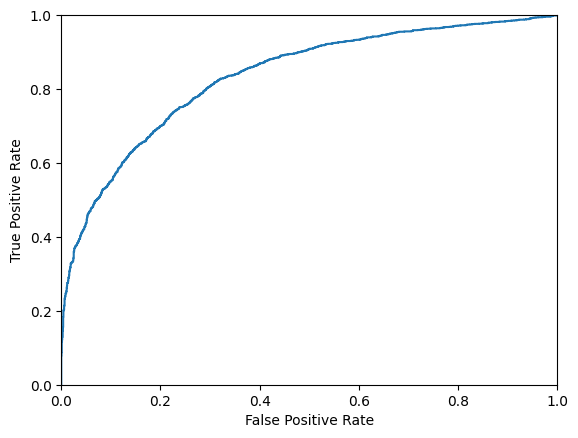

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# ROC曲線の描画
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.plot(fpr, tpr)
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()